# Le voyageur de commerce

Ce projet est inspiré du Chapitre 4 du livre “The Cross-Entropy Method” de
Rubinstein et Kroese.

Le problème du voyageur de commerce (en anglais, TSP, travelling salesman
problem) revient à minimiser le trajet effectué entre M villes, sous la contrainte
de passer par chaque ville exactement une fois. Soit D la matrice telle que Dij
est la distance entre la ville i et la ville j; noter que Dii = 0 et D est symétrique.

1) Rappeler (ou retrouver!) la méthode permettant de simuler efficacement
N vecteurs selon la loi Multinomiale définie par le vecteur de probabilité
p = (p1, . . . , pM). La mettre en œuvre.

In [1]:
%pylab inline
%load_ext line_profiler

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import seaborn

from scipy.stats import expon, uniform

from sklearn.preprocessing import normalize

(array([  970.,   996.,   980.,  1006.,  1010.,  1016.,  1018.,  1028.,
          997.,   979.]),
 array([  5.83535316e-05,   1.00031554e-01,   2.00004754e-01,
          2.99977955e-01,   3.99951155e-01,   4.99924356e-01,
          5.99897556e-01,   6.99870757e-01,   7.99843957e-01,
          8.99817157e-01,   9.99790358e-01]),
 <a list of 10 Patch objects>)

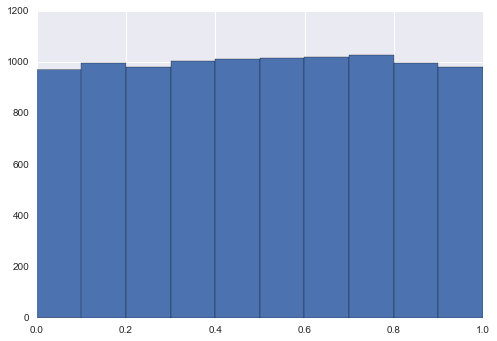

In [3]:
def sorted_uniforms(N):
    """
    Returns N sorted uniforms
    """
    E = expon.rvs(size=N+1)
    V = [sum(E[:i+1]) for i in range(N+1)]
    return V[:-1]/V[-1]

plt.hist(sorted_uniforms(10000))

In [4]:
def multinomial_su(P, N):
    """
    Returns a vector of N multinomials using sorted uniforms
    """
    su = sorted_uniforms(N)
    j = 0
    s = P[0]
    A = [0]
    for n in range(N):
        while su[n] > s:
            j += 1
            A += [0]
            s += P[j]
        A[j] += 1
        
    return A

In [5]:
def multinomial_bin(P,N):
    """ 
    Returs a vector of N multinomial using binomial distribution
    """
    number_simulated = 0
    n_coeffs = len(P)
    multinomials = np.zeros(n_coeffs)
    i = 0
    N_ = N
    while N_ > 0 and i < n_coeffs :
        N_ -= number_simulated
        binomial = uniform.rvs(size = N_)
        n_p = np.count_nonzero(binomial < P[i])
        multinomials[i] = np.count_nonzero(binomial < P[i])
        i+=1
    return multinomials

In [6]:
# Example
P = [1/4, 1/4, 1/4, 1/8, 1/8]
print(multinomial_su(P, 1000))
print(multinomial_bin(P, 1000))

[241, 254, 241, 123, 141]
[ 260.  267.  237.  128.  155.]


In [7]:
# Speed comparison
n = 10000
print("Multinomial (sorted uniforms method): ") 
%timeit multinomial_su(P, n)
print("Multinomial (binomial method): ")
%timeit multinomial_bin(P, n)
print("Numpy multinomial:")
%timeit np.random.multinomial(n, P, size=1)

Multinomial (sorted uniforms method): 
10 loops, best of 3: 64.5 ms per loop
Multinomial (binomial method): 
1000 loops, best of 3: 960 µs per loop
Numpy multinomial:
The slowest run took 430.65 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.99 µs per loop


2) Utiliser l’algorithme CE vu en cours pour résoudre le problème TSP. Pour
ce faire, proposer une famille paramétrique de lois pour la simulation de
trajets. Programmer cet algorithme, et le tester sur quelques exemples.

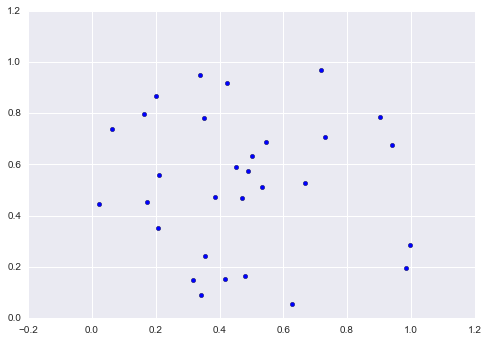

In [125]:
# Random cities
number_of_cities = 30
X = np.array([(np.random.rand(2)) for i in range(number_of_cities)])
plt.scatter(X[:,0], X[:,1])

D = np.empty((number_of_cities,number_of_cities))
for i in range(number_of_cities):
    D[i,i] = 0
    for j in range(number_of_cities):
        D[i,j] = np.linalg.norm(X[i]-X[j])
        D[j,i] = D[i,j]
        
# Random transition matrix P
P = np.reshape(np.random.rand(number_of_cities**2), (number_of_cities,number_of_cities))
for i in range(number_of_cities): 
    P[i,i] = 0
P = P/P.sum(axis=1)[:,None]

In [126]:
def one_step(d, P):
    """
    d represents partial trajectories and their number
    e.g. d = {(1,5,4,3):34, (1,3,6,7):16} means 34 partial trajectory went through (1,5,4,3) 
    The function generates the next step of the trajectory with P
    """
    new_dict = {}
    
    # d.keys() are all the partial trajectories
    for traj in d.keys():
        n = d[traj]
        if traj != 0:
            traj = list(traj)
        else:
            traj = [0]
        
        P1 = P.copy()
        
        # traj[-1] is the current vertex of the trajectory
        alpha = P1[traj[-1], :]
        
        # We set to zeros the column of the already visited vertices so they can't be visited twice
        alpha[traj[:-1]] = 0
        
        # Normalizes so alpha is a valid probability vector 
        alpha /= sum(alpha)
        
        # Generates the next step of the trajectory
        new = np.random.multinomial(n, alpha, size=1).tolist()[0]
        
        # Updates trajectories
        new_dict.update({ tuple(traj + [j]) : new[j] for j in range(1, len(new)) if new[j] != 0})
    
    # Returns the updated trajectories
    return new_dict

%lprun -f one_step multi_trajectories(P, 100)

In [127]:
def multi_trajectories(P, N):
    """
    Generates N stochastic trajectories according to transition matrix P
    """
    d = {(0):N}
    
    # We proceed step by step
    for i in range(len(P)-1):
        d = one_step(d, P)
    return d

In [128]:
def S(X, D):
    """
    Input: 
    X 1D-array representing a path on a graph
    D 2D-array distance matrice for the graph
    
    Output:
    The length of the path X (starting from X[0] and ending on X[0])
    
    """
    return sum([D[X[i], X[(i+1)%len(X)]] for i in range(len(X))])

In [129]:
def init_P(size):
    """
    Returns a stochastic matrix of dim size*size with zeros on the diagonal and 1/(size-1) elsewhere 
    """
    P = (np.ones((size, size)) - np.identity((size)))/(size-1)
    return P

init_P(3)

array([[ 0. ,  0.5,  0.5],
       [ 0.5,  0. ,  0.5],
       [ 0.5,  0.5,  0. ]])

In [130]:
def cross_entropy(C, n, rho=5, alpha=0.99):
    """
    Cross-entropy algorithm to find the best trajectory matrix
    """
    # Number of vertices
    degree = len(C)
    
    # Initial transition matrix
    P = init_P(degree)

    #length = [0,1]
    
    #while max(length) > min(length):
        
    length = [1]
    
    last_min = [0 for i in range(10)]
    
    while max(last_min) != min(length):
        # Generates n trajectories
        trajectories = multi_trajectories(P, n)
        
        # Sets the right format for the trajectories
        trajectories = [np.array(traj) for traj in trajectories.keys()]
        
        last_min = last_min[-9:] + [min(length)]
        
        # Computes the length of each trajectorie
        length = [S(trajectory, C) for trajectory in trajectories]
        
        # Percentile of order rho for the length of the trajectories
        gamma = np.percentile(length, rho, interpolation='lower')

        # Keeps only the best trajectories (length of trajectory < gamma )
        trajectories_sample = [traj for i, traj in enumerate(trajectories) if length[i] <= gamma]
        
        # Updates transition matrix 
        P_ = np.zeros(P.shape)
        for i in range(degree):
            for traj in trajectories_sample:
                P_[traj[i], traj[(i+1)%degree]] += 1/len(trajectories_sample)
        # Avoids getting zeros for non diagonal terms (otherwise it would create illicit trajectories)
        P = alpha * P_ + (1-alpha)* P            
    
    return P, gamma, trajectories_sample[0]

In [131]:
%lprun -f cross_entropy cross_entropy(D, 500)

In [137]:
P, gamma, best_traj =  cross_entropy(D, 500)

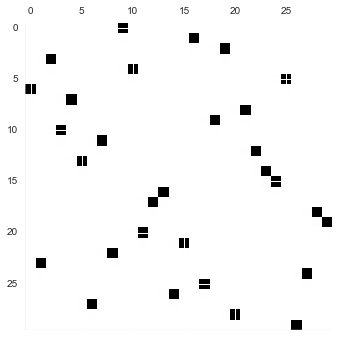

In [138]:
# We plot the matrix
plt.matshow(P,interpolation='none')

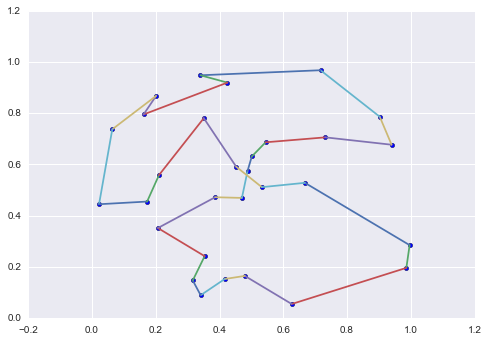

In [139]:
# We plot the best trajectory
for i in range(len(best_traj)):
    plt.plot((X[best_traj[i]][0], X[best_traj[(i+1)%len(best_traj)]][0]), (X[best_traj[i]][1], X[best_traj[(i+1)%len(best_traj)]][1]))
plt.scatter(X[:,0], X[:,1])

3) Concernant l’estimation bayésienne de vecteurs de probabilité d’une loi
multinomiale, retrouver le fait que la famille des lois de Dirichlet est
conjuguée pour ce modèle. Expliquer comment en pratique vous pouvez
utiliser cette propriété pour améliorer votre algorithme.

If $p = (p_1,...,p_k) \sim Dirichlet_k(\alpha_1, ..., \alpha_k)$, the density of $p$ is given by :
$$ \pi(p_1,...,p_k ; \alpha_1, ..., \alpha_k) = \dfrac{1}{B(\alpha)} \Pi_{i=1}^k p_i^{\alpha_i - 1} $$ 
for all $p_1,...,p_k >0$ such that $p_k = 1 - \sum_{j=1}^{k-1} p_j$.

If $x = (x_1,...,x_k) \sim Multinomial(p_1,...,p_k)$, the likelihood of $x$ is given by :

$$ L(x_1,...,x_k ; p_1,...,p_k) = \dfrac{ (\sum_i x_i)! }{x_1!...x_k!} \Pi_{i=1}^k p_i^{x_i} $$

We deduce :

$$ \pi(p_1,...,p_k ; \alpha_1, ..., \alpha_k, x_1,...,x_k) \propto \Pi_{i=1}^k p_i^{\alpha_i + x_i - 1} $$ 

Hence, by identification, $p|x \sim Dirichlet_k(\alpha_1 + x_1, ..., \alpha_k + x_k)$ so the Dirichlet distribution family is conjugate for this model.

In [55]:
def bayesian_multi_trajectories(alpha, N):
    l = []
    P = np.empty((len(alpha), len(alpha)))
    for j in range(N):
        for i in range(len(alpha)):
            P[i,:] = numpy.random.dirichlet(alpha[i,:])
            P[i,i] = 0
        P = P/P.sum(axis=1)[:,None]
        l += [trajectory(P)]
    return l

def trajectory(P):
    """
    """
    P_ = P.copy()
    X = np.zeros(len(P), np.int8)
    for i in range(len(P)-1):
        P_[:,X[i]] = 0
        P_ = P_/P_.sum(axis=1)[:,None]
        multi = np.random.multinomial(1, P_[X[i],:], size=1)
        X[i+1] = np.argmax(multi)
    return X

In [56]:
def bayesian_cross_entropy(C, n, rho=1):
    
    degree = len(C)
                
    alpha = np.ones((degree, degree))
    
    P = np.zeros((degree, degree))
    
    length = [1]
    
    last_min = [0 for i in range(10)]
    
    while max(last_min) != min(length):
        
        #trajectories = bayesian_multi_trajectories(alpha, n)        
        
        for i in range(len(alpha)):
            P[i,:] = numpy.random.dirichlet(alpha[i,:])
            P[i,i] = 0
        
        P = P/P.sum(axis=1)[:,None]
        
        trajectories = multi_trajectories(P, n)
                        
        trajectories = [np.array(traj) for traj in trajectories.keys()]
        
        last_min = last_min[-9:] + [min(length)]
        
        length = [S(trajectory, C) for trajectory in trajectories]
        
        gamma = np.percentile(length, rho, interpolation='lower')

        trajectories_sample = [traj for i, traj in enumerate(trajectories) if length[i] <= gamma]
        
        couples = [[(traj[i], traj[(i+1)%degree]) for i in range(degree)] for traj in trajectories_sample]
        
        for i in range(degree):
            for j in range(degree):
                alpha[i,j] += sum([1 for couple in couples if (i,j) in couple]) 
                
    best_traj = trajectories[min(range(len(length)), key=length.__getitem__)]
    
    return alpha, gamma, best_traj 

In [57]:
alpha_bayesian, gamma_bayesian, best_traj_bayesian = bayesian_cross_entropy(D, 100)

In [58]:
%lprun -f bayesian_multi_trajectories bayesian_multi_trajectories(alpha_bayesian, 100)

In [59]:
%lprun -f bayesian_cross_entropy bayesian_cross_entropy(D, 500)

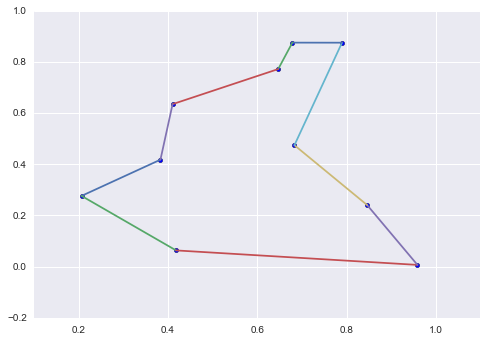

In [60]:
for i in range(len(best_traj_bayesian)):
    plt.plot((X[best_traj_bayesian[i]][0], X[best_traj_bayesian[(i+1)%len(best_traj)]][0]), (X[best_traj_bayesian[i]][1], X[best_traj_bayesian[(i+1)%len(best_traj)]][1]))
plt.scatter(X[:,0], X[:,1])

4) Bonus: en fonction du temps disponible, vous pouvez tester votre algorithme
sur de “gros” problèmes (par ex. trajet optimal du tour de France
en se basant sur la liste des villes de l’année dernière), ou comparer à
d’autres algorithmes que vous trouverez dans la littérature.

Faire tourner sur des villes random en France

In [76]:
import pandas as pd
# https://opendata.paris.fr/explore/dataset/arbresremarquablesparis2011/table/
df = pd.read_csv('arbresremarquablesparis2011.csv', sep=';')
# arbutus ou sequoia
df = df[df['GENRE']=='Sequoia']

In [78]:
geo_points = df['Geo point'].tolist()
nb_trees = len(geo_points)
geo_points = [(float(geo_point_str.split(',')[0]), float(geo_point_str.split(',')[1])) for geo_point_str in geo_points]

In [79]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [80]:
D_trees = numpy.empty((nb_trees,nb_trees))
for i in range(nb_trees):
    D_trees[i,i] = 0
    for j in range(nb_trees):
        lon1, lat1 = geo_points[i][0], geo_points[i][1]
        lon2, lat2 = geo_points[j][0], geo_points[j][1]
        D_trees[i,j] = haversine(lon1, lat1, lon2, lat2)
        D_trees[j,i] = D_trees[i,j]

In [ ]:
alpha, gamma, best_traj = cross_entropy(D_trees, 1500)

In [ ]:
import folium
from IPython.display import HTML

map_osm = folium.Map(location=[48.85, 2.34])

polyline_best_traj = [geo_points[point] for point in best_traj] + [geo_points[0]]

for i in range(len(geo_points)-1):
    folium.Marker(geo_points[i], popup='Sequoia').add_to(map_osm)

folium.PolyLine(polyline_best_traj, color="red", weight=2.5, opacity=1).add_to(map_osm)

map_osm